# Number reversal

This document presents the results of a comparison of the approaches to solving the "number reversal" task.

The task is to write a program that takes an integer as input and returns an integer formed by reversing its decimal digits.

The goal is to compare time performance and RAM consumption of different approaches for numbers with varying lengths in their decimal representation.

In [ ]:
import numpy as np
import pandas as pd
from random import randint
from datetime import datetime
from collections import Counter
from typing import Callable, cast

## Approaches

**Generally, there are two contrasting approaches:**

* Transform the number into a `str` and operate on it as an array of characters.
* Extract the digits of the number by repeatedly taking the remainder when divided by 10 and discarding the processed digits.

---

The following code implements a "transforming to string" approach.

In [1]:
def reverse_through_str(var: int) -> int:
    return int(str(var)[::-1])

reverse_through_str(693)

396

A one-line task.

The implementation of the second approach is shown below.

In [2]:
def separate_digits(var: int) -> list[int]:
    ans = list[int]()
    flag = True

    while flag:

        if var < 10:
            flag = False

        digit = var % 10
        ans.append(digit)
        var = (var - digit) // 10
    return ans


def reverse_through_digits(var: int) -> int:
    dig_lst = separate_digits(var=var)[::-1]

    ans = 0
    for i, v in enumerate(dig_lst):
        ans += v * (10 ** (i))
    return ans

reverse_through_digits(var=8942)

2498

It's a bit more complex, but it doesn't require converting an integer to a string, which can potentionaly be an expensive operation.

## Time performance

---

The following code demonstrates the procedure used to estimate the time performance of the approaches under consideration. For $n$-digit numbers, where $n \in \left\{100, 200, 300, 400\right\}$, it runs both implementations and records the results.

In [5]:
def estimate_time(num: int, fun: Callable[[int], int]) -> float:
    before = datetime.now()
    fun(num)
    return (datetime.now() - before).total_seconds()

timings_str = dict[int, list[float]]()
timings_digits = dict[int, list[float]]()

low, top = 0, 9
for i in range(100, 500, 100):

    low = 10 ** (i - 1)
    top = (10 ** i) - 1

    experiments_str = list[float]()
    experiments_digits = list[float]()

    for _ in range(1000):
        experiments_str.append(
            estimate_time(randint(low, top), reverse_through_str)
        )
        experiments_digits.append(
            estimate_time(randint(low, top), reverse_through_digits)
        )
    
    timings_str[i] = experiments_str
    timings_digits[i] = experiments_digits

timings_str = pd.DataFrame(timings_str)
timings_str.columns.name = "Digits"
timings_str = cast(pd.Series, timings_str.unstack()).rename("Time (seconds)").reset_index()
timings_str["Approach"] = "str transform"

timings_digits = pd.DataFrame(timings_digits)
timings_digits.columns.name = "Digits"
timings_digits = cast(pd.Series, timings_digits.unstack()).rename("Time (seconds)").reset_index()
timings_digits["Approach"] = "extract digits"

timings_str = cast(pd.DataFrame, timings_str)
timings_digits = cast(pd.DataFrame, timings_digits)
data = pd.concat([timings_str, timings_digits])
data["log Time (microseconds)"] = np.log(data["Time (seconds)"] * (10 ** 6))

The next code visualizes the results of the experiment.

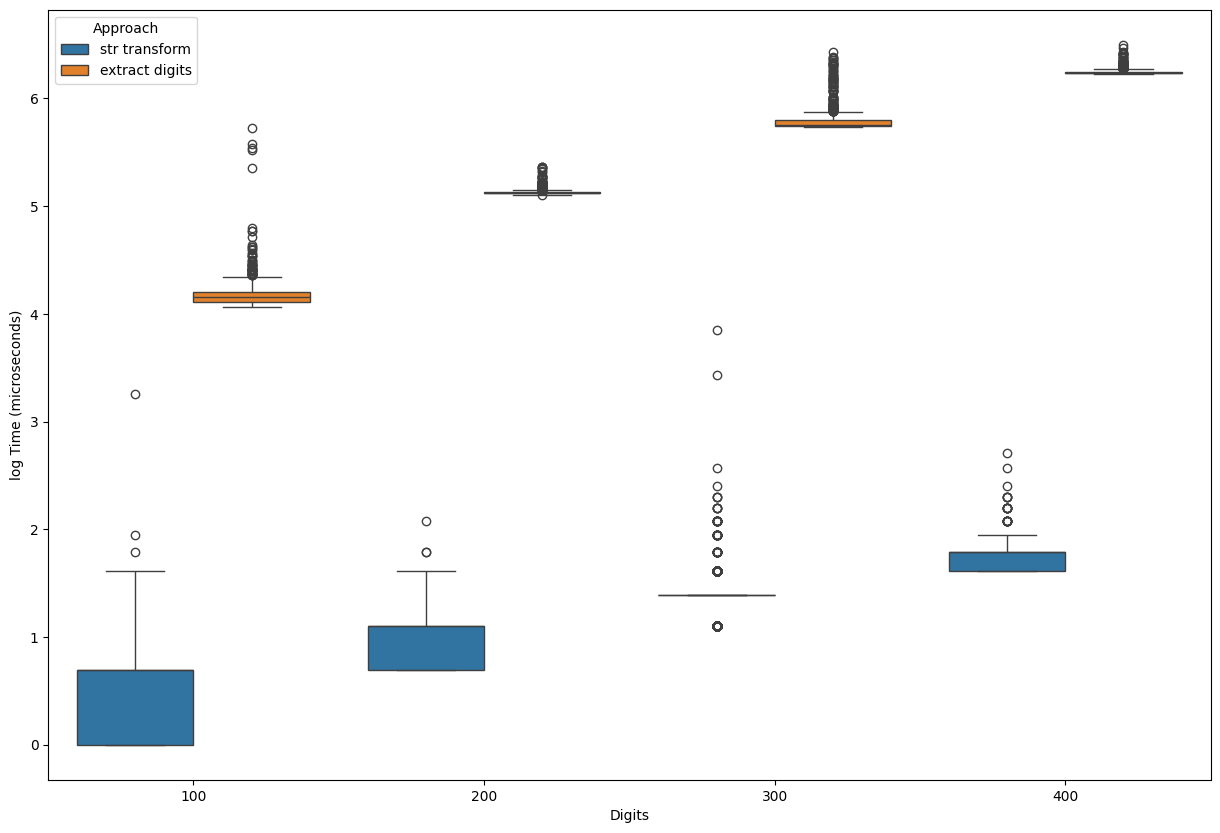

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
sns.boxplot(data=data, x="Digits", y="log Time (microseconds)", hue="Approach")
plt.show()

The transformation to the string approach asymptotically faster (there is logarithmic scale on the picture).

## Memory consumption

---

The next code represents the procedure that was used to estimate the memory consumption associated when using different approaches. It's generally the same as time performance estimation, just uses a different function to estimate the metric of interest.

In [47]:
import tracemalloc

def estimate_ram(num: int, fun: Callable[[int], int]) -> float:
    tracemalloc.start()
    tracemalloc.clear_traces()
    fun(num)
    _, peak = tracemalloc.get_traced_memory()
    return peak

ram_str = dict[int, list[float]]()
ram_digits = dict[int, list[float]]()

low, top = 0, 9
for i in range(100, 500, 100):

    low = 10 ** (i - 1)
    top = (10 ** i) - 1

    experiments_str = list[float]()
    experiments_digits = list[float]()

    for _ in range(1000):
        experiments_str.append(
            estimate_ram(randint(low, top), reverse_through_str)
        )
        experiments_digits.append(
            estimate_ram(randint(low, top), reverse_through_digits)
        )
    
    ram_str[i] = experiments_str
    ram_digits[i] = experiments_digits

Results from different runs with the same number of digits in the reversed number are typically consistent. Therefore, the best way to present the results is in a table that shows the number of experiments corresponding to each memory consumption value for a given digit count.

In [66]:
def prepare_frame(results: dict[int, list[float]]) -> pd.DataFrame:
    res = pd.DataFrame({k: dict(Counter(v)) for k, v in results.items()})
    res.fillna(0, inplace=True)
    res = res.astype(int)
    res.index.name = "Bytes consumed"
    res.columns.name = "Digits number"
    return res

**Convert to string**

In [71]:
display(prepare_frame(ram_str))

Digits number,100,200,300,400
Bytes consumed,,,,
282,1000,0,0,0
482,0,1000,0,0
682,0,0,1000,0
882,0,0,0,1000


**Digit extraction**

In [70]:
display(prepare_frame(ram_digits))

Digits number,100,200,300,400
Bytes consumed,,,,
1720,998,0,0,0
1897,1,0,0,0
2035,1,0,0,0
3256,0,1000,0,0
4920,0,0,1000,0
6456,0,0,0,999
7100,0,0,0,1


Obviously, the approach that involves converting to a string requires less memory, and as the number of processed digits increases, the relative difference in memory usage also grows.

## Conclusion

The approach that involves converting the number to a string, reversing it, and then converting it back to an integer is superior in every aspect: it's much easier to implement and consumes less time and memory.

The reason why it's happening isn't clear. Builtin convert to a string must, at some stage, rely on the same concept of digit separation as used here in the custom approach. Presumably, direct implementation on C allows for more effective results.